In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import seaborn as sn 
from seaborn import heatmap

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Loading Data:
The dataset has been splited into 20% for validation and 80% for training.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
train_data_path = '/content/gdrive/My Drive/Data3/train_ds'
test_data_path = '/content/gdrive/My Drive/Data3/test_ds'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

Found 24770 files belonging to 45 classes.
Using 19816 files for training.
Found 6760 files belonging to 45 classes.
Using 1352 files for validation.
['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']
0.12941177 1.0


**Run 1:**
The relu activation function has been used in Con2D layers and MaxPooling layers. 
The optimizer in this run is Adam.

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                    

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 48s 62ms/step - loss: 3.0838 - accuracy: 0.1764 - val_loss: 2.6104 - val_accuracy: 0.2655
Epoch 2/50
620/620 [==============================] - 9s 15ms/step - loss: 2.1676 - accuracy: 0.3818 - val_loss: 2.2374 - val_accuracy: 0.3654
Epoch 3/50
620/620 [==============================] - 9s 15ms/step - loss: 1.4850 - accuracy: 0.5672 - val_loss: 1.9222 - val_accuracy: 0.4556
Epoch 4/50
620/620 [==============================] - 9s 15ms/step - loss: 0.8688 - accuracy: 0.7438 - val_loss: 2.1221 - val_accuracy: 0.4726
Epoch 5/50
620/620 [==============================] - 9s 15ms/step - loss: 0.4394 - accuracy: 0.8711 - val_loss: 2.5912 - val_accuracy: 0.4763
Epoch 6/50
620/620 [==============================] - 9s 15ms/step - loss: 0.2383 - accuracy: 0.9280 - val_loss: 2.9257 - val_accuracy: 0.4712
Epoch 7/50
620/620 [==============================] - 9s 15ms/step - loss: 0.1620 - accuracy: 0.9534 - val_loss: 3.3848 - val_accuracy: 0.425

**The accuracy for Run 1:**

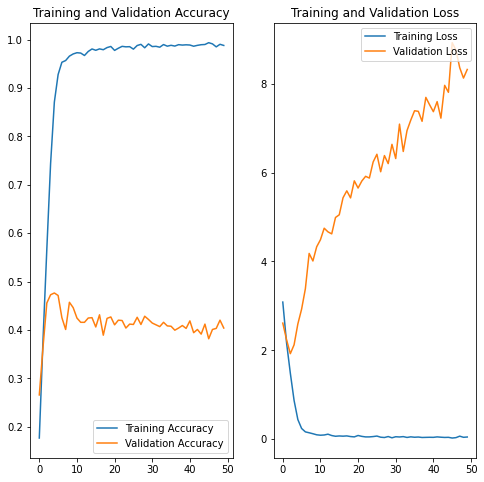

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 0s 8ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.69      0.25      0.37        36
           1       0.17      0.14      0.15        22
           2       0.37      0.48      0.42        29
           3       0.22      0.19      0.21        31
           4       0.38      0.69      0.49        26
           5       0.73      0.53      0.62        30
           6       0.76      0.68      0.72        19
           7       0.25      0.19      0.21        27
           8       0.64      0.25      0.36        28
           9       0.80      0.69      0.74        29
          10       0.23      0.29      0.26        34
          11       0.18      0.45      0.26        33
          12       0.94      0.75      0.83        40
          13       0.52      0.79      0.63        33
          14       0.17      0.24      0.20        33
          15       0.29      0.36      0.32     

<Figure size 432x288 with 0 Axes>

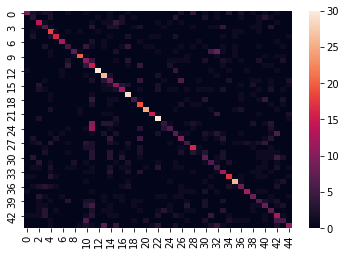

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 2:**
based on the previous run, The accuracy for training has improved but the accuracy in validation has not shown much enhancement.
Hence, Dropout and Kernal Regularizer in this run has been used to improve the validation accuracy.
In each layer, 20% Dropout has been used. 

In [ ]:
lambda2 = 0.0002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 11s 16ms/step - loss: 3.1249 - accuracy: 0.1579 - val_loss: 2.5535 - val_accuracy: 0.2996
Epoch 2/50
620/620 [==============================] - 10s 15ms/step - loss: 2.2199 - accuracy: 0.3808 - val_loss: 2.2401 - val_accuracy: 0.3809
Epoch 3/50
620/620 [==============================] - 10s 16ms/step - loss: 1.7918 - accuracy: 0.4853 - val_loss: 1.9565 - val_accuracy: 0.4379
Epoch 4/50
620/620 [==============================] - 10s 15ms/step - loss: 1.4548 - accuracy: 0.5780 - val_loss: 1.8198 - val_accuracy: 0.4837
Epoch 5/50
620/620 [==============================] - 10s 15ms/step - loss: 1.1942 - accuracy: 0.6505 - val_loss: 1.7549 - val_accuracy: 0.5155
Epoch 6/50
620/620 [==============================] - 10s 15ms/step - loss: 0.9928 - accuracy: 0.7130 - val_loss: 1.7276 - val_accuracy: 0.5444
Epoch 7/50
620/620 [==============================] - 10s 15ms/step - loss: 0.8068 - accuracy: 0.7665 - val_loss: 1.9106 - val_accuracy:

**The accuracy for Run 2:**

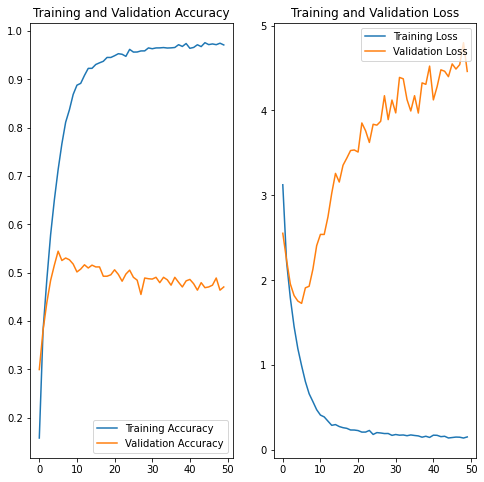

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 0s 9ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.61      0.47      0.53        36
           1       0.20      0.45      0.28        22
           2       0.60      0.41      0.49        29
           3       0.21      0.19      0.20        31
           4       0.48      0.46      0.47        26
           5       0.63      0.73      0.68        30
           6       0.77      0.89      0.83        19
           7       0.53      0.30      0.38        27
           8       0.69      0.32      0.44        28
           9       0.65      0.69      0.67        29
          10       0.32      0.47      0.38        34
          11       0.46      0.48      0.47        33
          12       0.89      0.78      0.83        40
          13       0.71      0.76      0.74        33
          14       0.28      0.27      0.28        33
          15       0.35      0.29      0.31     

<Figure size 432x288 with 0 Axes>

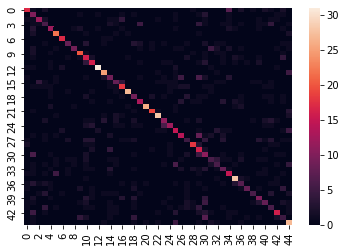

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 3:**
in this run more layers have been added to check the improvement.
Also, the optimizer in this run is SGD with learning rate= 0.01.
In addition, the L2 regularizer is much more than the previous models, to test the result.

In [ ]:
lambda2 = 0.02

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 15s 22ms/step - loss: 8.5056 - accuracy: 0.0399 - val_loss: 7.2921 - val_accuracy: 0.0555
Epoch 2/50
620/620 [==============================] - 13s 21ms/step - loss: 6.3767 - accuracy: 0.0839 - val_loss: 5.7749 - val_accuracy: 0.0769
Epoch 3/50
620/620 [==============================] - 13s 21ms/step - loss: 5.1305 - accuracy: 0.1116 - val_loss: 4.6611 - val_accuracy: 0.1598
Epoch 4/50
620/620 [==============================] - 13s 21ms/step - loss: 4.2795 - accuracy: 0.1627 - val_loss: 3.8823 - val_accuracy: 0.1967
Epoch 5/50
620/620 [==============================] - 13s 21ms/step - loss: 3.6448 - accuracy: 0.2195 - val_loss: 3.3990 - val_accuracy: 0.2648
Epoch 6/50
620/620 [==============================] - 13s 21ms/step - loss: 3.2077 - accuracy: 0.2683 - val_loss: 3.1430 - val_accuracy: 0.2433
Epoch 7/50
620/620 [==============================] - 13s 21ms/step - loss: 2.9042 - accuracy: 0.3115 - val_loss: 2.9893 - val_accuracy:

**The accuracy for Run 3:**

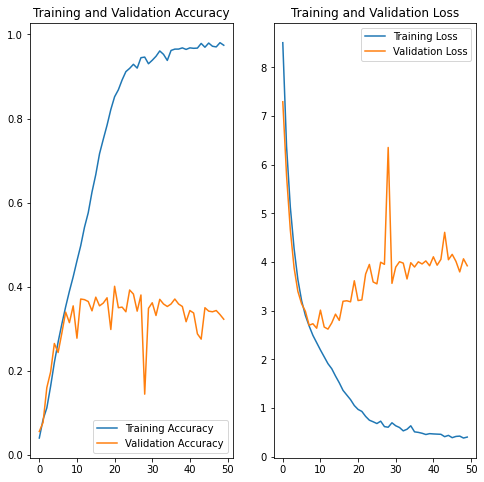

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 10ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.39      0.39      0.39        36
           1       0.14      0.18      0.16        22
           2       0.37      0.45      0.41        29
           3       0.10      0.06      0.08        31
           4       0.41      0.58      0.48        26
           5       0.44      0.53      0.48        30
           6       0.55      0.32      0.40        19
           7       0.27      0.26      0.26        27
           8       0.27      0.21      0.24        28
           9       0.29      0.52      0.38        29
          10       0.13      0.24      0.17        34
          11       0.19      0.15      0.17        33
          12       0.71      0.90      0.79        40
          13       0.43      0.55      0.48        33
          14       0.26      0.27      0.26        33
          15       0.25      0.25      0.25    

<Figure size 432x288 with 0 Axes>

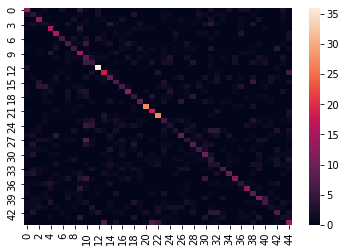

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 4:**
The activation function in some layers are changed to softmax.

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(num_classes)
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                 

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 14s 21ms/step - loss: 4.3997 - accuracy: 0.0223 - val_loss: 4.3849 - val_accuracy: 0.0229
Epoch 2/50
620/620 [==============================] - 13s 21ms/step - loss: 4.3707 - accuracy: 0.0232 - val_loss: 4.3569 - val_accuracy: 0.0163
Epoch 3/50
620/620 [==============================] - 13s 21ms/step - loss: 4.3431 - accuracy: 0.0233 - val_loss: 4.3303 - val_accuracy: 0.0163
Epoch 4/50
620/620 [==============================] - 13s 21ms/step - loss: 4.3161 - accuracy: 0.0260 - val_loss: 4.3049 - val_accuracy: 0.0163
Epoch 5/50
620/620 [==============================] - 13s 21ms/step - loss: 4.2872 - accuracy: 0.0236 - val_loss: 4.2802 - val_accuracy: 0.0163
Epoch 6/50
620/620 [==============================] - 13s 21ms/step - loss: 4.2591 - accuracy: 0.0233 - val_loss: 4.2568 - val_accuracy: 0.0274
Epoch 7/50
620/620 [==============================] - 13s 21ms/step - loss: 4.2308 - accuracy: 0.0346 - val_loss: 4.2341 - val_accuracy:

**The accuracy for Run 4:**

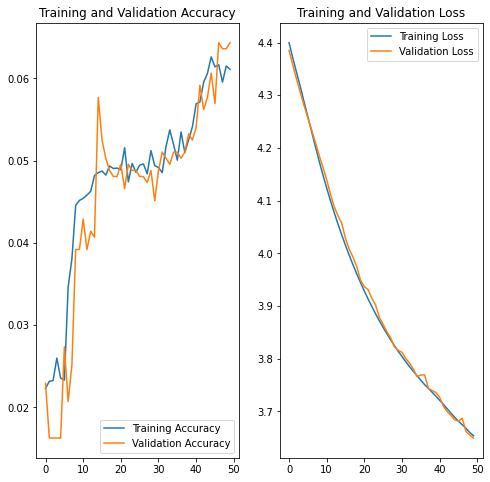

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 11ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.03      0.08      0.04        36
           1       0.06      0.09      0.07        22
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        26
           5       0.04      0.17      0.06        30
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        29
          10       0.00      0.00      0.00        34
          11       0.00      0.00      0.00        33
          12       0.00      0.00      0.00        40
          13       0.00      0.00      0.00        33
          14       0.00      0.00      0.00        33
          15       0.05      0.50      0.09    

<Figure size 432x288 with 0 Axes>

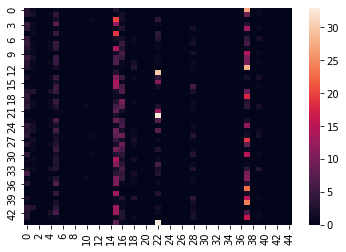

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Run 5:
Different layers and models have been tested in this run. 

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                 

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 14s 22ms/step - loss: 4.3051 - accuracy: 0.0413 - val_loss: 4.2205 - val_accuracy: 0.0666
Epoch 2/50
620/620 [==============================] - 13s 21ms/step - loss: 3.9360 - accuracy: 0.1090 - val_loss: 4.0736 - val_accuracy: 0.0962
Epoch 3/50
620/620 [==============================] - 13s 21ms/step - loss: 3.5536 - accuracy: 0.1880 - val_loss: 3.5242 - val_accuracy: 0.1805
Epoch 4/50
620/620 [==============================] - 13s 21ms/step - loss: 3.2068 - accuracy: 0.2632 - val_loss: 3.2491 - val_accuracy: 0.2308
Epoch 5/50
620/620 [==============================] - 13s 21ms/step - loss: 2.9017 - accuracy: 0.3337 - val_loss: 3.1881 - val_accuracy: 0.2522
Epoch 6/50
620/620 [==============================] - 13s 21ms/step - loss: 2.6557 - accuracy: 0.3912 - val_loss: 2.7806 - val_accuracy: 0.3528
Epoch 7/50
620/620 [==============================] - 13s 21ms/step - loss: 2.4227 - accuracy: 0.4469 - val_loss: 2.8084 - val_accuracy:

**The accuracy for Run 5:**

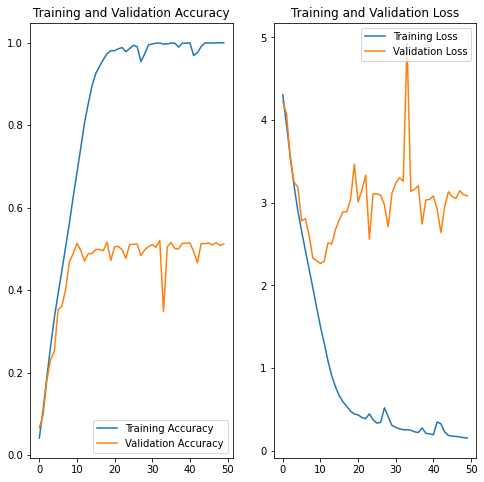

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 10ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.69      0.64        36
           1       0.32      0.45      0.38        22
           2       0.46      0.45      0.46        29
           3       0.35      0.35      0.35        31
           4       0.51      0.77      0.62        26
           5       0.61      0.67      0.63        30
           6       0.57      0.68      0.62        19
           7       0.38      0.37      0.38        27
           8       0.63      0.68      0.66        28
           9       0.64      0.79      0.71        29
          10       0.20      0.24      0.21        34
          11       0.41      0.33      0.37        33
          12       0.81      0.88      0.84        40
          13       0.68      0.76      0.71        33
          14       0.40      0.36      0.38        33
          15       0.41      0.39      0.40    

<Figure size 432x288 with 0 Axes>

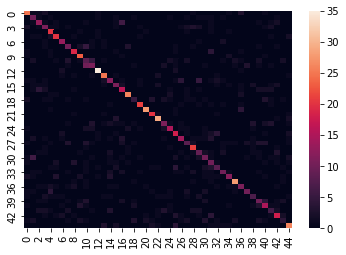

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 6:**

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer = l2(lambda2)),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                 

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 23s 35ms/step - loss: 6.6814 - accuracy: 0.0487 - val_loss: 6.5400 - val_accuracy: 0.0717
Epoch 2/50
620/620 [==============================] - 21s 35ms/step - loss: 6.1329 - accuracy: 0.1281 - val_loss: 5.9465 - val_accuracy: 0.1679
Epoch 3/50
620/620 [==============================] - 21s 35ms/step - loss: 5.6078 - accuracy: 0.2100 - val_loss: 5.3762 - val_accuracy: 0.2581
Epoch 4/50
620/620 [==============================] - 21s 35ms/step - loss: 5.1887 - accuracy: 0.2843 - val_loss: 5.1079 - val_accuracy: 0.2996
Epoch 5/50
620/620 [==============================] - 21s 35ms/step - loss: 4.8648 - accuracy: 0.3335 - val_loss: 4.7790 - val_accuracy: 0.3661
Epoch 6/50
620/620 [==============================] - 21s 34ms/step - loss: 4.5560 - accuracy: 0.3881 - val_loss: 4.4549 - val_accuracy: 0.4290
Epoch 7/50
620/620 [==============================] - 21s 34ms/step - loss: 4.2747 - accuracy: 0.4392 - val_loss: 4.3373 - val_accuracy:

**The accuracy for Run 6:**

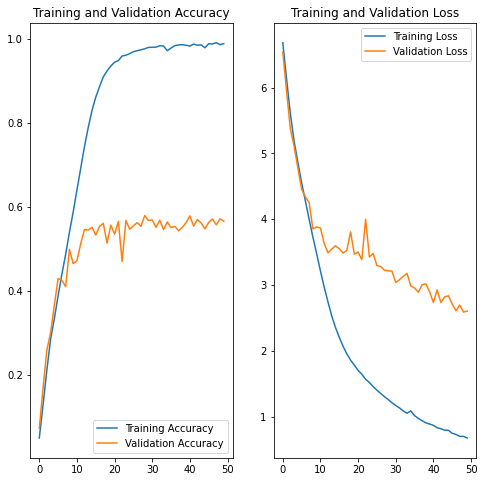

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 14ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.40      0.86      0.55        36
           1       0.28      0.36      0.31        22
           2       0.46      0.45      0.46        29
           3       0.45      0.29      0.35        31
           4       0.78      0.81      0.79        26
           5       0.60      0.70      0.65        30
           6       0.57      0.89      0.69        19
           7       0.46      0.41      0.43        27
           8       0.68      0.89      0.77        28
           9       0.72      0.62      0.67        29
          10       0.44      0.35      0.39        34
          11       0.57      0.64      0.60        33
          12       0.80      0.88      0.83        40
          13       0.76      0.79      0.78        33
          14       0.50      0.45      0.48        33
          15       0.47      0.54      0.50    

<Figure size 432x288 with 0 Axes>

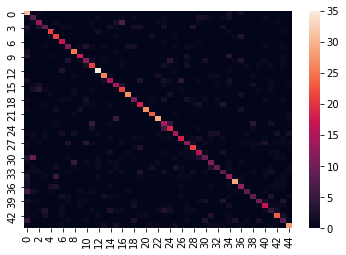

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 7:**
The BachNormalization has been added to each layer. 
Also, the activation function for all layers is still relu except for the last layer. 
In last layer, the Softmax activation have been used.

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(54, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer = l2(lambda2))
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 54)     

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 18s 26ms/step - loss: 5.8374 - accuracy: 0.1912 - val_loss: 7.4012 - val_accuracy: 0.0732
Epoch 2/50
620/620 [==============================] - 16s 25ms/step - loss: 5.0385 - accuracy: 0.3340 - val_loss: 7.3987 - val_accuracy: 0.0851
Epoch 3/50
620/620 [==============================] - 16s 25ms/step - loss: 4.5846 - accuracy: 0.4171 - val_loss: 7.7619 - val_accuracy: 0.0836
Epoch 4/50
620/620 [==============================] - 16s 25ms/step - loss: 4.2169 - accuracy: 0.4940 - val_loss: 7.2432 - val_accuracy: 0.1050
Epoch 5/50
620/620 [==============================] - 16s 25ms/step - loss: 3.9472 - accuracy: 0.5420 - val_loss: 5.8583 - val_accuracy: 0.1975
Epoch 6/50
620/620 [==============================] - 16s 25ms/step - loss: 3.6986 - accuracy: 0.5937 - val_loss: 5.6253 - val_accuracy: 0.2152
Epoch 7/50
620/620 [==============================] - 16s 25ms/step - loss: 3.4756 - accuracy: 0.6334 - val_loss: 4.7166 - val_accuracy:

**The accuracy for Run 7:**

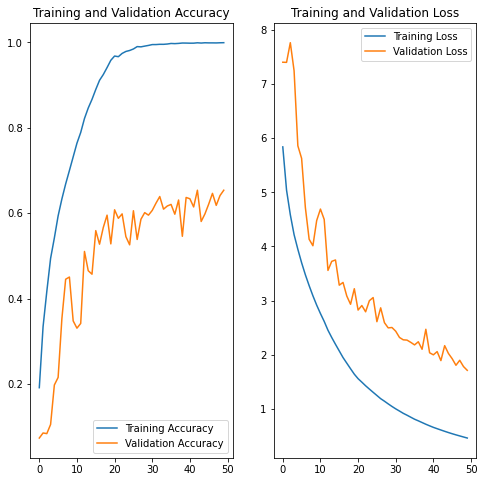

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 10ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.69      0.78        36
           1       0.52      0.50      0.51        22
           2       0.78      0.48      0.60        29
           3       0.54      0.48      0.51        31
           4       0.61      0.77      0.68        26
           5       0.84      0.90      0.87        30
           6       0.85      0.89      0.87        19
           7       0.86      0.44      0.59        27
           8       0.71      0.79      0.75        28
           9       0.73      0.93      0.82        29
          10       0.62      0.44      0.52        34
          11       0.63      0.73      0.68        33
          12       0.89      0.85      0.87        40
          13       0.60      0.85      0.70        33
          14       0.50      0.48      0.49        33
          15       0.69      0.64      0.67    

<Figure size 432x288 with 0 Axes>

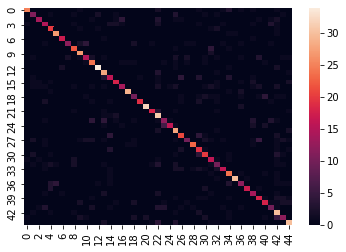

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 8:**
The learning rate has been changed to 0.03 in this run.

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.BatchNormalization(),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer = l2(lambda2))
])
model.compile(optimizer=SGD(0.03), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_32 (Conv2D)          (None, 128, 128, 64)     

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 17s 26ms/step - loss: 5.8268 - accuracy: 0.2059 - val_loss: 6.3248 - val_accuracy: 0.1191
Epoch 2/50
620/620 [==============================] - 16s 25ms/step - loss: 4.8609 - accuracy: 0.3513 - val_loss: 5.4976 - val_accuracy: 0.1945
Epoch 3/50
620/620 [==============================] - 16s 25ms/step - loss: 4.2704 - accuracy: 0.4406 - val_loss: 5.0789 - val_accuracy: 0.2544
Epoch 4/50
620/620 [==============================] - 16s 25ms/step - loss: 3.8479 - accuracy: 0.5031 - val_loss: 4.3997 - val_accuracy: 0.3543
Epoch 5/50
620/620 [==============================] - 16s 25ms/step - loss: 3.4944 - accuracy: 0.5471 - val_loss: 4.6254 - val_accuracy: 0.2922
Epoch 6/50
620/620 [==============================] - 16s 25ms/step - loss: 3.2058 - accuracy: 0.5902 - val_loss: 3.8100 - val_accuracy: 0.4357
Epoch 7/50
620/620 [==============================] - 16s 25ms/step - loss: 2.9641 - accuracy: 0.6264 - val_loss: 4.2268 - val_accuracy:

**The accuracy for Run 8:**

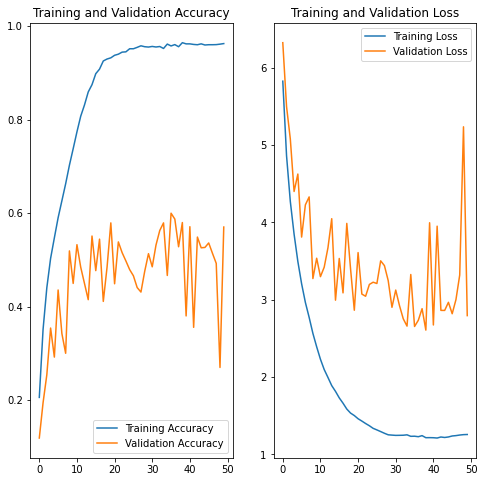

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 10ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.40      0.75      0.52        36
           1       0.30      0.27      0.29        22
           2       0.75      0.31      0.44        29
           3       0.67      0.32      0.43        31
           4       0.50      0.88      0.64        26
           5       0.64      0.83      0.72        30
           6       1.00      0.74      0.85        19
           7       0.83      0.37      0.51        27
           8       0.90      0.32      0.47        28
           9       0.68      0.93      0.78        29
          10       0.41      0.21      0.27        34
          11       0.79      0.45      0.58        33
          12       0.89      0.82      0.86        40
          13       0.92      0.67      0.77        33
          14       0.52      0.48      0.50        33
          15       0.70      0.50      0.58    

<Figure size 432x288 with 0 Axes>

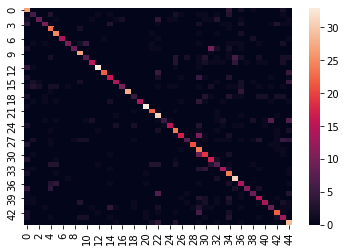

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 9: Accuracy: 69%**
**The Best Result**
different layers and hyperparameters in layers have been used in this run.
Also, another dropout have been added.

In [ ]:
lambda2 = 0.002

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer = l2(lambda2)),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax', kernel_regularizer = l2(lambda2))
])
model.compile(optimizer=SGD(0.01), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 64)     

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
620/620 [==============================] - 21s 32ms/step - loss: 5.9842 - accuracy: 0.2144 - val_loss: 6.9274 - val_accuracy: 0.1050
Epoch 2/50
620/620 [==============================] - 19s 31ms/step - loss: 5.0248 - accuracy: 0.3690 - val_loss: 7.2252 - val_accuracy: 0.1679
Epoch 3/50
620/620 [==============================] - 20s 32ms/step - loss: 4.5053 - accuracy: 0.4670 - val_loss: 6.3068 - val_accuracy: 0.2655
Epoch 4/50
620/620 [==============================] - 20s 32ms/step - loss: 4.1163 - accuracy: 0.5518 - val_loss: 5.1618 - val_accuracy: 0.3824
Epoch 5/50
620/620 [==============================] - 20s 32ms/step - loss: 3.7735 - accuracy: 0.6220 - val_loss: 4.2324 - val_accuracy: 0.5148
Epoch 6/50
620/620 [==============================] - 20s 32ms/step - loss: 3.4849 - accuracy: 0.6844 - val_loss: 4.2058 - val_accuracy: 0.5170
Epoch 7/50
620/620 [==============================] - 20s 32ms/step - loss: 3.2307 - accuracy: 0.7402 - val_loss: 4.3395 - val_accuracy:

**The accuracy for Run 9:**

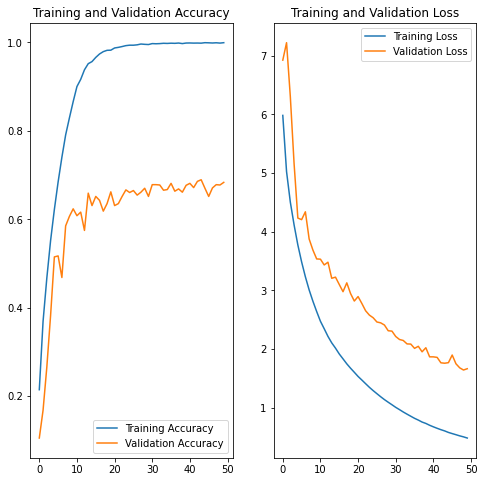

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 10ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.63      0.75      0.68        36
           1       0.44      0.50      0.47        22
           2       0.69      0.62      0.65        29
           3       0.60      0.48      0.54        31
           4       0.56      0.85      0.68        26
           5       0.84      0.87      0.85        30
           6       0.95      1.00      0.97        19
           7       0.85      0.41      0.55        27
           8       0.68      0.93      0.79        28
           9       0.67      0.97      0.79        29
          10       0.55      0.50      0.52        34
          11       0.89      0.52      0.65        33
          12       0.97      0.90      0.94        40
          13       0.81      0.79      0.80        33
          14       0.57      0.64      0.60        33
          15       0.68      0.75      0.71    

<Figure size 432x288 with 0 Axes>

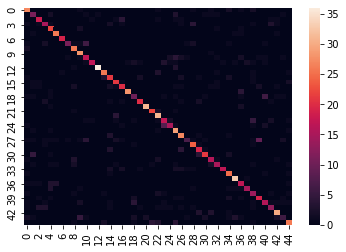

<Figure size 432x288 with 0 Axes>

In [ ]:
# predict the labels of the test set
predictedY = model.predict(val_ds)
predictedY = np.argmax(predictedY, axis=1)
testY = np.concatenate([y for x, y in val_ds], axis=0)

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

**Run 10: Accuracy: 68%**
Resnet for this dataset.
The dataset has been trained and tested on Resnet in this run with 20 Epochs.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
import pandas as pd
import warnings
import math
import os
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.activations import relu
from keras.activations import linear
from tensorflow.keras.layers import *
from tensorflow.keras import layers as Layers
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
from keras.models import Sequential #Import from keras_preprocessing not from keras.preprocessingfrom keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras_preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
import pathlib
from tensorflow.keras import datasets, layers, models

class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(45)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x


model = ResNet34()
model.build(input_shape=(1, 256, 256, 3))
model.summary()

Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_13 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 max_pooling2d_39 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 ResBlock (ResBlock)         multiple                  74368     
                                                                 
 ResBlock (ResBlock)         multiple                  743

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128
)

Epoch 1/20
620/620 [==============================] - 35s 49ms/step - loss: 3.4168 - accuracy: 0.1039 - val_loss: 13.9099 - val_accuracy: 0.0814
Epoch 2/20
620/620 [==============================] - 30s 48ms/step - loss: 2.9664 - accuracy: 0.1814 - val_loss: 6.8005 - val_accuracy: 0.1050
Epoch 3/20
620/620 [==============================] - 30s 48ms/step - loss: 2.7075 - accuracy: 0.2398 - val_loss: 2.8743 - val_accuracy: 0.2315
Epoch 4/20
620/620 [==============================] - 30s 48ms/step - loss: 2.5143 - accuracy: 0.2823 - val_loss: 2.9356 - val_accuracy: 0.3609
Epoch 5/20
620/620 [==============================] - 30s 48ms/step - loss: 2.2972 - accuracy: 0.3344 - val_loss: 2.3177 - val_accuracy: 0.3624
Epoch 6/20
620/620 [==============================] - 30s 48ms/step - loss: 2.1276 - accuracy: 0.3789 - val_loss: 2.3693 - val_accuracy: 0.3499
Epoch 7/20
620/620 [==============================] - 30s 48ms/step - loss: 1.9651 - accuracy: 0.4232 - val_loss: 2.4364 - val_accuracy

**The accuracy for Run 10:**

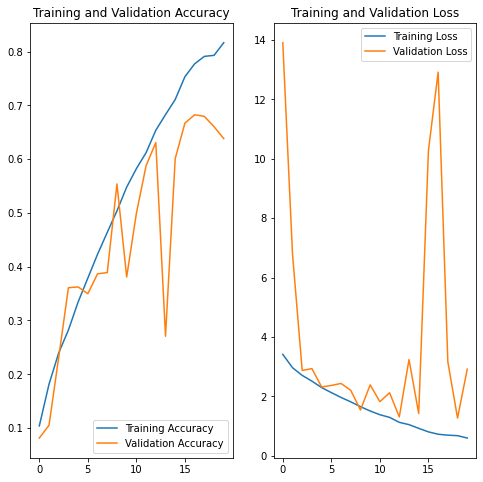

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

43/43 [==============================] - 1s 16ms/step

Testing Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.50      0.64        36
           1       0.27      0.86      0.41        22
           2       0.83      0.52      0.64        29
           3       0.65      0.48      0.56        31
           4       0.35      0.92      0.51        26
           5       0.79      0.77      0.78        30
           6       0.94      0.79      0.86        19
           7       0.65      0.48      0.55        27
           8       0.74      0.71      0.73        28
           9       0.96      0.83      0.89        29
          10       0.70      0.41      0.52        34
          11       0.89      0.52      0.65        33
          12       0.89      0.80      0.84        40
          13       0.79      0.67      0.72        33
          14       0.83      0.61      0.70        33
          15       0.80      0.57      0.67    

<Figure size 432x288 with 0 Axes>

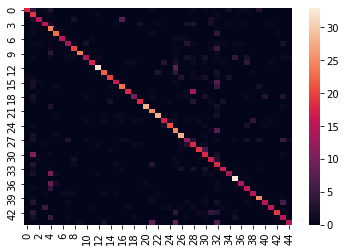

<Figure size 432x288 with 0 Axes>

In [ ]:
predictedY = model.predict(val_ds)
predictedY =  np.argmax(predictedY,axis= 1 )
testY = np.concatenate([y for x, y in val_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Summary:
through testing different models, I realized the Relu activation function worke better with this dataset. Although, the activation function used in last layer is Softmax. The Elu and Sigmoid did not perform well with this dataset. Also, dropout and L2 regulizer improved the result significantly. The Resnet and Ensemble had a really good result with this dataset. In addition, adding more layers to the model improves the validation accuracy. eventhough, adding too many  layers, may not improve the accuracy.
I used two notebooks. I figured out one kernall is not enough for this 13 runs.
I ran the Resnet model with this dataset 3 times. The accuracy with Resnet is 84%.